In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from datetime import date, datetime
import time
import matplotlib.pyplot as plt
import urllib.request
from tqdm import tqdm
import pickle
import spacy
import random
import ast
import seaborn as sns
import networkx as nx

In [3]:
# getting stpwords from nltk
nltk.download('stopwords')
stopword_set = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/auppal8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
tqdm.pandas()

In [5]:
pd.set_option('display.max_colwidth', -1)

In [6]:
df_following = pd.read_excel('/home/auppal8/updatedfollowingData1117.xlsx', index_col=0)

In [7]:
df_timeline = pd.read_csv('/home/auppal8/userTimelineData.csv',lineterminator='\n',)

In [8]:
# getting the burst timeline..
df_tweets = pd.read_csv('/home/auppal8/HexagonData_new.csv',lineterminator='\n', index_col=None)

In [9]:
df_tweets1 = pd.read_csv('~/hexagonData.csv',lineterminator='\n', index_col=None)

In [10]:
# following data for user...
df_300 = pd.read_csv("~/Following300_1220.csv",index_col=0)

In [11]:
len(set(df_tweets1.userID))

7371

In [12]:
df_tweet = df_tweets1

In [13]:
df_tweet.columns

Index(['favourites_count', 'friendList', 'friendsCount', 'hashtags',
       'imageurl', 'lang', 'retweetCount', 'retweeted', 'tweetCreatedAt',
       'tweetId', 'tweetText', 'userCreatedAt', 'userDescription',
       'userFollowersCount', 'userID', 'userLocation', 'userName\r'],
      dtype='object')

In [14]:
df_tweet['tweetCreatedAt'] = pd.to_datetime(df_tweet.tweetCreatedAt)

In [15]:
ds_tweet =  df_tweet.groupby(by = [df_tweet['tweetCreatedAt'].dt.date])['tweetId'].agg({"count":pd.Series.nunique})

/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


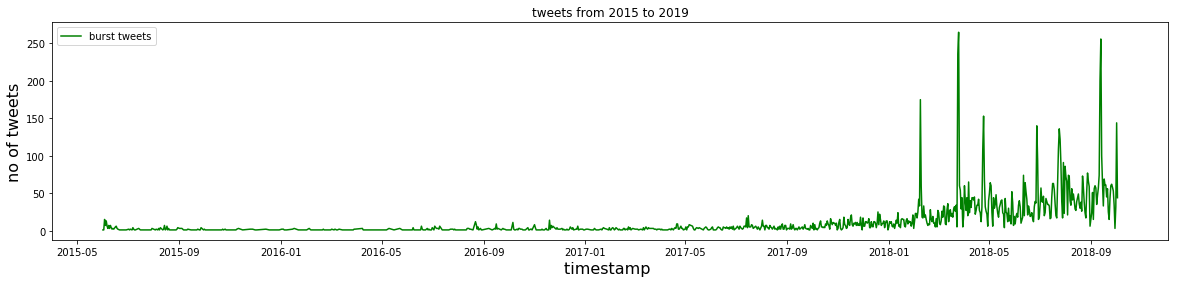

In [16]:
# plotting the tweet ids
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(list(ds_tweet.index),list(ds_tweet['count']),color = 'green', label='burst tweets')
plt.ylabel("no of tweets",fontsize=16)
plt.xlabel("timestamp ", fontsize = 16)
plt.title("tweets from 2015 to 2019")
plt.legend()
plt.show() 

In [17]:
## peak detection algorithm
#!/usr/bin/env python
# Implementation of algorithm from https://stackoverflow.com/a/22640362/6029703
import numpy as np
import pylab

# param y: value in which we detect the peak
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [18]:
#calculating the peaks..
influence = 0.5
lag = 0
y = ds_tweet['count'].values
threshold = 125
result = thresholding_algo(y,lag,threshold,influence)

/home/auppal8/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/auppal8/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/auppal8/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/auppal8/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/auppal8/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-1.5, 1.5)

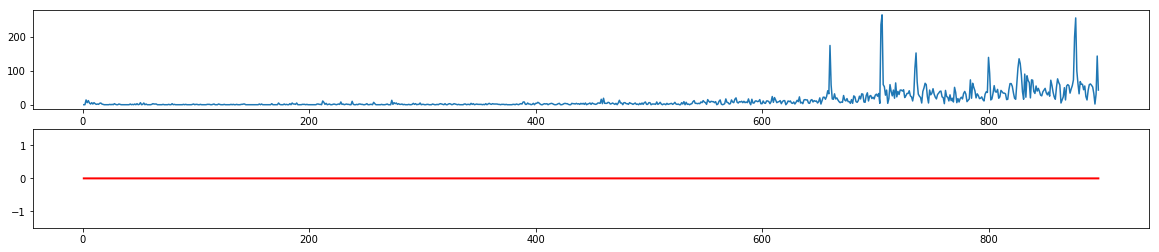

In [19]:
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"], color="cyan", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

pylab.subplot(212)
pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
pylab.ylim(-1.5, 1.5)

In [20]:
# getting simple peaks based on a threshold value
threshold = 125
peaks =  ds_tweet[ds_tweet['count'] > threshold].index

In [21]:
# filtering the URL from the text
df_tweets['tweetText']

0        Happy 12th to this thugga 🔞 #juul #shleep https://t.co/bI7UiuOXPv                                                                                                                                                                                                                                                                
1        Just as good as it looks, try #Juul today! - vaporshark  -  | PHOTO | VIDEO | DESIGN | Bring… https://t.co/8nKW3BcI5h                                                                                                                                                                                                            
2        Happy 12th to this thugga 🔞 #juul #shleep https://t.co/bI7UiuOXPv                                                                                                                                                                                                                                                                
3      

In [22]:
# using this regex..
url = df_tweets['tweetText'].str.extract("(https?://\S+)").dropna()[0]
url.reset_index(drop=True,inplace=True)

In [23]:
# to get the expanded url
def resolve_url(url):
    try:
        fp = urllib.request.urlopen(url)
        return fp.geturl()
    except urllib.error.HTTPError as e:
        return(np.nan)
    except urllib.error.URLError as e:
        return(np.nan)

In [27]:
urlt = url[:50]

In [28]:
import multiprocessing
pool = multiprocessing.Pool(10)

In [29]:
%time
resolved_urls = []
for longurl in tqdm(pool.map(resolve_url, urlt)): ##change t url
    resolved_urls.append(longurl)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 11.9 µs


100%|██████████| 50/50 [00:00<00:00, 58044.62it/s]


In [30]:
with open('test.pkl','wb') as f:
    pickle.dump(resolved_urls, f)

In [31]:
(resolved_urls) = list(resolved_urls)

In [32]:
resolved_urls = [x for x in resolved_urls if x != 'nan']

In [33]:
# need to get all of the urls
len(resolved_urls)

50

In [34]:
# apply logistic regression..get the attributes for user
## complete user ..data then start with logistic...
## get user..

In [35]:
# userss.
df_tweets.columns

Index(['favourites_count', 'friendList', 'friendsCount', 'hashtags',
       'imageurl', 'lang', 'retweetCount', 'retweeted', 'tweetCreatedAt',
       'tweetId', 'tweetText', 'userCreatedAt', 'userDescription',
       'userFollowersCount', 'userID', 'userLocation', 'userName'],
      dtype='object')

In [36]:
df_user = df_tweets[['userID','favourites_count','friendsCount','userFollowersCount']].copy()

In [37]:
df_user.set_index('userID',inplace=True)

In [38]:
# no of users in original user tweets from hexagon_new
len(list(df_user.index.unique()))

7228

In [39]:
# no of users in tweets from hexagon
len(df_tweets1.userID.unique())

7371

In [40]:
# no of users in timeline
len(list(df_timeline.userID.unique()))

7372

In [41]:
# take the bag of words of all the user tweets and get the average word vector for users...
B = set(df_tweets.userID.unique())
A = set(df_timeline.userID.unique())
C = set(df_tweets1.userID.unique())
C.issubset(A)

True

In [42]:
userId = list(df_timeline.userID.unique())

In [43]:
# one extra user in timeline data
len(userId)

7372

In [44]:
user_tweets_no = df_timeline.groupby(df_timeline['userID'])['tweetId'].agg(['count']).sort_values('count',ascending=True)


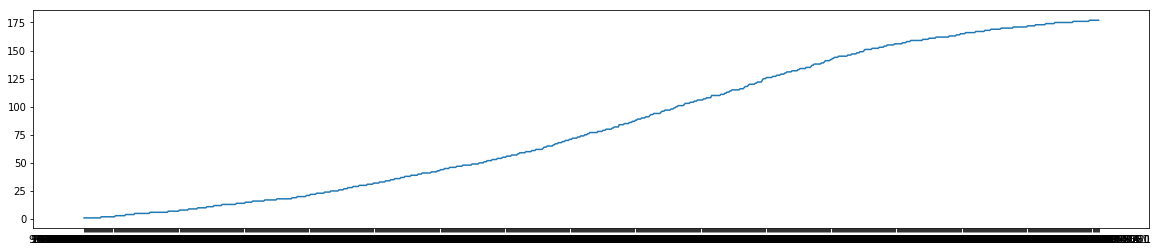

In [45]:
plt.plot([str(user) for user in user_tweets_no.index][:1000],user_tweets_no['count'][:1000])
plt.show()

In [46]:
# as we are testing on small taking a random sample of 300 users
userId = user_tweets_no[user_tweets_no['count'] >= 200]

In [47]:
# get only the users which have equal no of tweets
userIdR = random.sample(list(userId.index),300)
# userIdR = list(userId.index)
df_users = df_timeline[df_timeline.userID.isin(userIdR)]

In [48]:
len(df_users.userID.unique())

300

In [49]:
# preprocess the tweet text

In [50]:
df_users['tweetText'] = df_users['tweetText'].str.lower().str.split()

/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
# removing the stop words
df_users['tweetText'] = df_users['tweetText'].apply(lambda x: [item for item in x if item not in stopword_set])

/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
df_users['tweetText'] = df_users['tweetText'].str.join(" ")

/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
# removing non english characters and urls from the text
pattern = re.compile(r'([^\w\s\/:@])|(https?://\S+)')
df_users['tweetText'] = df_users['tweetText'].str.replace(pattern,"")

/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
df_users['tweetText'] = df_users['tweetText'].str.lstrip().str.rstrip()

/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
df_users.reset_index(inplace= True)

In [56]:
from spacy.lang.en import English
parser = English()

In [57]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [58]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

[nltk_data] Downloading package wordnet to /home/auppal8/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
# using sklearn..Deprecated..dont run
# vocalb = list(user_two['tweetText'].values)
# vocalb = list(set([item for sublist in vocalb for item in sublist]))

In [60]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [61]:
# think of better way to vectorize this
df_users['tweetText'] = df_users['tweetText'].progress_apply(prepare_text_for_lda)

100%|██████████| 60000/60000 [00:36<00:00, 1641.54it/s]
/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
df_users['tweetText'] = df_users['tweetText'].str.join(" ")

/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
# function that will take all teh users and caluclate their average tfiddf mean of all the tweets
from sklearn.feature_extraction.text import TfidfVectorizer
def get_tfidf_mean(df):
    if('userID' in df):
        user_vectors = []
        users = list(df['userID'].unique())  
        user_tweets_no = df.groupby(df['userID'])['tweetId'].agg(['count'])
        if len(user_tweets_no['count'].unique()) is 1: # check for cosine similarity with compatible sizes
            for user in tqdm(users):
                user_i = df[df['userID'] == user]
                tfidf = TfidfVectorizer().fit_transform(user_i['tweetText'].values)
                useri_vec = (np.mean((tfidf * tfidf.T).A,axis=1))
                user_vectors.append(useri_vec)
        return user_vectors

In [64]:
def cosine_similarity(a,b):
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [65]:
users_tfidf = get_tfidf_mean(df_users)

100%|██████████| 300/300 [00:02<00:00, 101.82it/s]


In [66]:
mat = np.zeros((0,len(userIdR)))
for userA in tqdm(users_tfidf):
    temp = list()
    for userB in (users_tfidf):
        match = cosine_similarity(userA,userB)
        temp.append(match)
    mat = np.vstack((mat,temp))

100%|██████████| 300/300 [00:00<00:00, 653.78it/s]


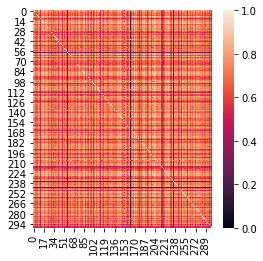

In [67]:
# mat
plt.rcParams["figure.figsize"] = (4,4)
ax = sns.heatmap(mat)
plt.title
plt.show()

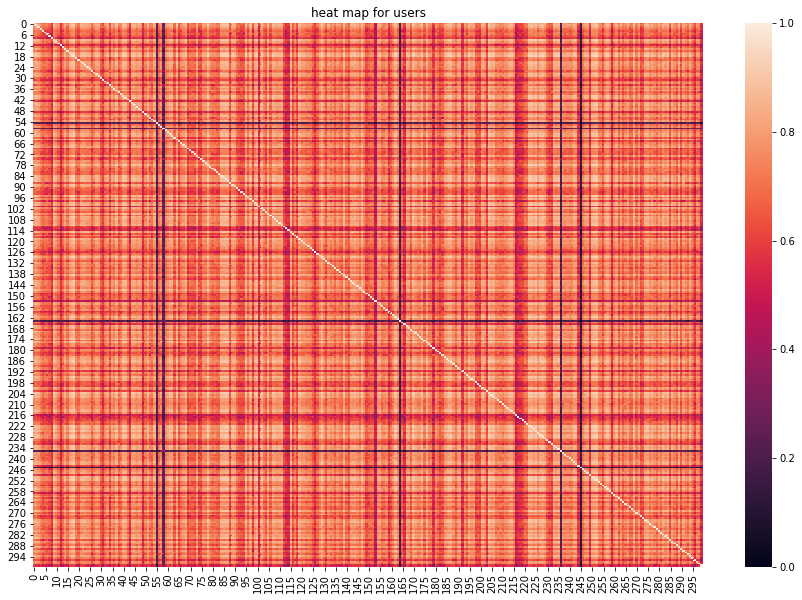

In [68]:
import seaborn as sns
# mat
plt.rcParams["figure.figsize"] = (15,10)
ax = sns.heatmap(mat)
plt.title("heat map for users")
plt.show()

In [69]:
from sklearn.metrics.pairwise import cosine_similarity
matc = cosine_similarity(users_tfidf, users_tfidf)

In [70]:
# resetting as url were removed
df_users = df_timeline[df_timeline.userID.isin(userIdR)]

In [71]:
# now using jaccard similarity with the urls..
# to measure user similarity we use jaccard to get similarity between them
# using this regex..
df_users['urls'] = df_users['tweetText'].str.extract("(https?://\S+)")

/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [72]:
df_users.reset_index(inplace=True)

In [73]:
df_users['urls'] = df_users['urls'].replace(np.nan,"")

/home/auppal8/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
# using shortened urls only
user_urls = df_users.groupby('userID')['urls'].apply(lambda col:','.join(col))

In [75]:
users = list(df_users['userID'].unique())
len(users)

300

In [76]:
# checking with pair of users
sim = np.zeros((0,len(users)))
users = df_users['userID'].unique()
for userA in tqdm(users):
    temp = list()
    for userB in users:
        user1_urls = set(user_urls[userA].split(","))
        user2_urls = set(user_urls[userB].split(","))
        #jaccard
        match = len(set.intersection(user1_urls,user2_urls)) / len(set.union(user1_urls,user2_urls))
        temp.append(match)
    sim = np.vstack((sim,temp))                                               

100%|██████████| 300/300 [00:08<00:00, 35.33it/s]


In [77]:
## extarct the users as per the 300 bunch
df_foll = df_following[df_following.index.isin(userIdR)]

In [78]:
len(userIdR)

300

In [79]:
# check with following users..jaccard coefficient
# checking with pair of users
users = (userIdR)
sim_f = np.zeros((0,len(userIdR)))
for userA in tqdm(users):
    temp = list()
    for userB in users:
        if ((userA in df_300.index) and (userB in df_300.index)):
            user1_urls = set(ast.literal_eval(df_300.loc[userA]['following']))
            user2_urls = set(ast.literal_eval(df_300.loc[userB]['following']))
            #jaccard
            y = len(set.union(user1_urls,user2_urls))
            if (y == 0):
                match = 0
            else:
                match = len(set.intersection(user1_urls,user2_urls)) / len(set.union(user1_urls,user2_urls))
        else:
            match = 0
        temp.append(match)
    sim_f = np.vstack((sim_f,temp))                                               

100%|██████████| 300/300 [00:03<00:00, 86.19it/s] 


In [80]:
#average of all of the similarities
similarity = (sim_f + sim + mat) / 3

In [81]:
(np.mean(similarity))

0.23241709097812904

In [82]:
a = np.arange(0,1,0.01)

In [83]:
A = list()
a = np.arange(0,1,0.01)
for value in a:
    temp = len(similarity[similarity >= value])
    A.append(temp)

Text(0.5, 1.0, 'No of edges vs threshold')

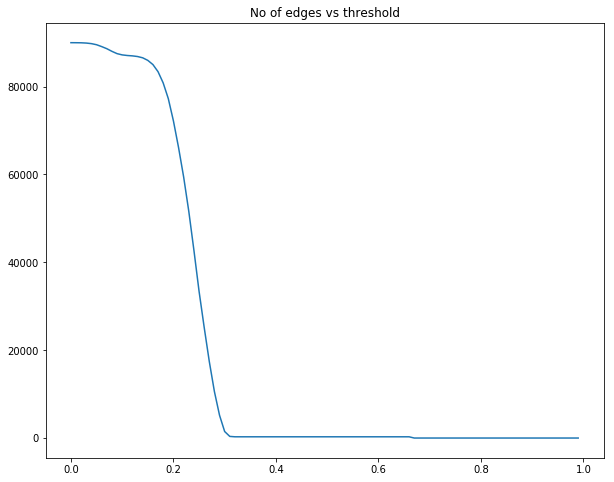

In [85]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(a,A)
plt.title("No of edges vs threshold")

In [86]:
# setting 0.65 as the threshold
len(similarity[similarity>=0.65])

300

In [87]:
df_similarity = pd.DataFrame(similarity,columns=userIdR,index = userIdR)

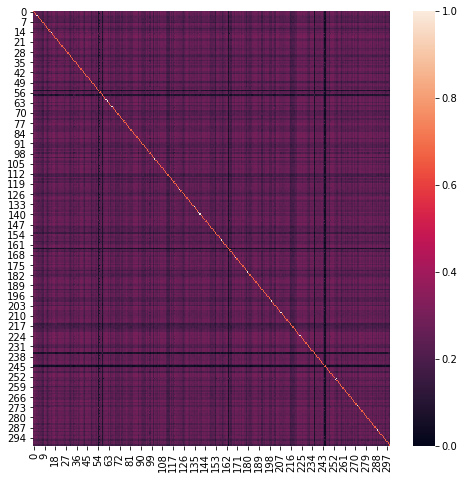

In [88]:
plt.rcParams["figure.figsize"] = (8,8)
ax = sns.heatmap(similarity)
plt.show()

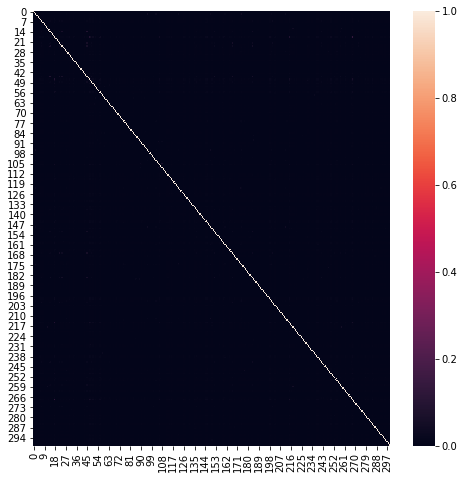

In [89]:
temp = (sim)
plt.rcParams["figure.figsize"] = (8,8)
ax = sns.heatmap(temp)
plt.show()

In [90]:
sim

array([[1.        , 0.        , 0.00309598, ..., 0.00307692, 0.003003  ,
        0.00396825],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00309598, 0.        , 1.        , ..., 0.00334448, 0.00325733,
        0.00442478],
       ...,
       [0.00307692, 0.        , 0.00334448, ..., 1.        , 0.00323625,
        0.00438596],
       [0.003003  , 0.        , 0.00325733, ..., 0.00323625, 1.        ,
        0.00423729],
       [0.00396825, 0.        , 0.00442478, ..., 0.00438596, 0.00423729,
        1.        ]])

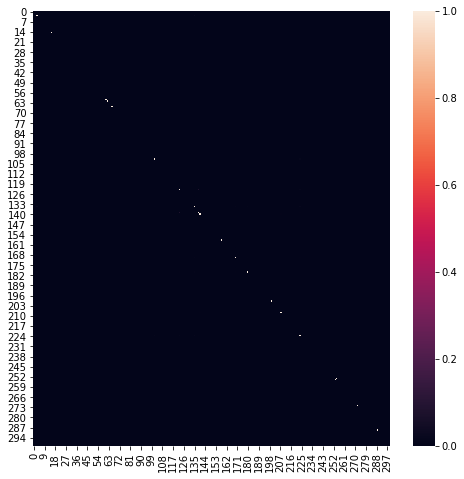

In [91]:
plt.rcParams["figure.figsize"] = (8,8)
ax = sns.heatmap(sim_f)
plt.show()

In [93]:
# setting 0.65 as the threshold
(similarity[similarity<0.65]) = 0

In [95]:
len((similarity[similarity>=0.65]))

300

In [96]:
similarity = np.matrix(similarity)
Graph = nx.from_numpy_matrix(similarity)

In [98]:
with open('user-user.pkl','wb') as f:
    pickle.dump(similarity, f)

/home/auppal8/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


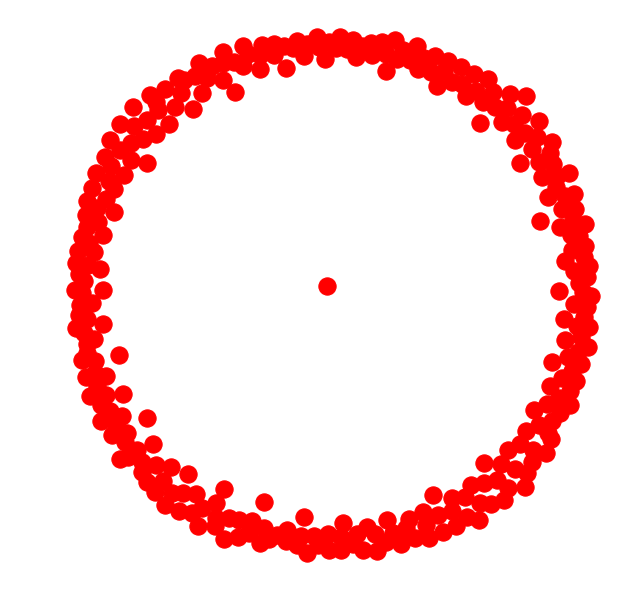

In [97]:
nx.draw(Graph)